### Case 2 (Figure 3b, 6b)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import math
import numpy as np
import matplotlib.pyplot as plt
from math import log, e
import torch.optim as optim
import pickle
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
plt.rcParams.update({'font.size': 20, 'figure.figsize': (8,4.5), 'font.family':'Arial', 'axes.axisbelow':True})

torch.manual_seed(22) 
np.random.seed(22)

DIR_NAME = 'inner_prod/'
SAVE=True
GROUP_SIZE=0.98
NOISE=1/8

In [2]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, small=True):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, out_channel*2, int(input_dim/patch_num), int(input_dim/patch_num))        
        if small:
            self.conv1.weight = torch.nn.Parameter(self.conv1.weight*0.1) 
            self.conv1.bias = torch.nn.Parameter(self.conv1.bias*0.1) 
        self.out_channel = out_channel

    def forward(self, x):
        x = self.conv1(x)
        x = x**3
        x = torch.sum(x,2)
        output = torch.stack([torch.sum(x[:,:self.out_channel],1), torch.sum(x[:,self.out_channel:],1)]).transpose(1,0)
        return output

In [3]:
def train(model, criterion, data, labels, optimizers, epochs=100, plot=False, verbose=True):
    min_loss = 100
    core, spu, loss_list = [], [], []
    core_inner, spu_inner = test_inner(model)
    core.append(core_inner)
    spu.append(spu_inner)


    for epoch in range(epochs):  
        
        for optimizer in optimizers:
            optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels) 
        loss_list.append(loss.detach())
        loss.backward() 
        core_inner, spu_inner = test_inner(model)
        core.append(core_inner)
        spu.append(spu_inner)


        for optimizer in optimizers:
            optimizer.step()
        
        if epoch%100 == 0:
            if verbose:
                print('Epoch %d --- loss: %.3f' % (epoch + 1, loss.item()))
    
    core, spu, loss_list = torch.stack(core), torch.stack(spu), torch.stack(loss_list)
    print('Finished Training')
    return core, spu, loss_list


def test(model, criterion, data, labels):
    correct = 0
    
    with torch.no_grad():
        outputs = model(data)
        predicted = torch.max(outputs.data, 1).indices
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %.4f %%' % (data.shape[0],
        100 * correct / data.shape[0]))
    
    return 100 * correct / data.shape[0]


def test_inner(model):
    with torch.no_grad():
        core_inner = torch.max(torch.abs(torch.matmul(model.conv1.weight.squeeze(1), 
                                                      vc.float().unsqueeze(1).cuda())))
        spurious_inner = torch.max(torch.abs(torch.matmul(model.conv1.weight.squeeze(1), 
                                                          vs.float().unsqueeze(1).cuda())))
    return core_inner, spurious_inner

In [4]:
DATA_NUM = 10000
PATCH_NUM = 3
PATCH_LEN = 50

def div_norm(x):
    x /= np.linalg.norm(x)
    return x

vc = np.random.randn(PATCH_LEN) 
vc /= np.linalg.norm(vc)

vs = np.random.randn(PATCH_LEN) 
vs /= np.linalg.norm(vs)
vs -= vs.dot(vc) * vc
vs /= np.linalg.norm(vs)

vc, vs = torch.tensor(vc), torch.tensor(vs)

data = []
data_visual = []
labels = []
spurious_labels = []

xi_large, xi_small = torch.zeros(PATCH_LEN), torch.zeros(PATCH_LEN)

for i in range(DATA_NUM*2):
    y = np.random.choice([-1,1], 1)[0] 
    alpha = np.random.uniform(0,1)
    # Feature noise patch
    a = (alpha<GROUP_SIZE)*y - (alpha>=GROUP_SIZE)*y
    # Noise patch
    xi = torch.tensor(np.random.normal(0, NOISE, size=(PATCH_LEN)))
    
    if a==y:
        xi_large+=xi
    else:
        xi_small+=xi

    core = vc*y 
    spurious = vs*a/5
    x = torch.stack([core, spurious, xi])
    
    x_visual = torch.stack([core*1.2, spurious, xi])
    
    x = x.flatten()
    x_visual = x_visual.flatten()

    data.append(x)
    data_visual.append(x_visual)
    labels.append(y)
    spurious_labels.append(a)

data = torch.stack(data)
data_visual = torch.stack(data_visual)
print(data.shape)

labels = torch.tensor(labels)
spurious_labels = torch.tensor(spurious_labels)
labels[labels==-1] = 0
spurious_labels[spurious_labels==-1]=0
print(labels.shape)

training_data = data[:DATA_NUM,:].unsqueeze(1).float().cuda()
test_data = data[DATA_NUM:,:].unsqueeze(1).float().cuda()

print(training_data.shape, test_data.shape)

training_labels = labels[:DATA_NUM].cuda()
test_labels = labels[DATA_NUM:].cuda()
spurious_training_labels = spurious_labels[:DATA_NUM].cuda()
spurious_test_labels = spurious_labels[DATA_NUM:].cuda()
print(training_labels.shape, test_labels.shape)

training_labels = training_labels.long()
test_labels = test_labels.long()
spurious_training_labels = spurious_training_labels.long()
spurious_test_labels = spurious_test_labels.long()

torch.Size([20000, 150])
torch.Size([20000])
torch.Size([10000, 1, 150]) torch.Size([10000, 1, 150])
torch.Size([10000]) torch.Size([10000])


In [5]:
for i in range(DATA_NUM):
    idx = torch.randperm(PATCH_NUM)
    stack_data = torch.stack([training_data[i,0,:][j*PATCH_LEN:(j+1)*PATCH_LEN] for j in range(PATCH_NUM)])
    stack_data = stack_data[idx].flatten()
    training_data[i,0,:] = stack_data

    idx = torch.randperm(PATCH_NUM)
    stack_data = torch.stack([test_data[i,0,:][j*PATCH_LEN:(j+1)*PATCH_LEN] for j in range(PATCH_NUM)])
    stack_data = stack_data[idx].flatten()
    test_data[i,0,:] = stack_data

In [6]:
small_test_data = torch.concat([test_data[[x and y for x,y in zip(test_labels==1,spurious_test_labels==0)]],test_data[[x and y for x,y in zip(test_labels==0,spurious_test_labels==1)]]])
small_test_label = torch.concat([test_labels[[x and y for x,y in zip(test_labels==1,spurious_test_labels==0)]],test_labels[[x and y for x,y in zip(test_labels==0,spurious_test_labels==1)]]])

Accuracy of the network on the 10000 test images: 44.1400 %
Accuracy of the network on the 229 test images: 41.4847 %
Epoch 1 --- loss: 0.693
Epoch 101 --- loss: 0.693
Epoch 201 --- loss: 0.693
Epoch 301 --- loss: 0.039


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Epoch 401 --- loss: 0.001
Finished Training
Accuracy of the network on the 10000 test images: 100.0000 %
Accuracy of the network on the 229 test images: 100.0000 %


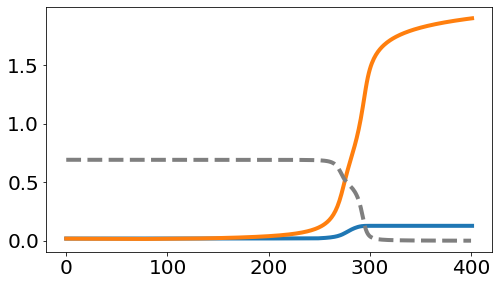

In [7]:
num_epochs = 401

CNN = ConvNet(PATCH_LEN*PATCH_NUM, 20, PATCH_NUM).cuda() 
pred = CNN(test_data)
criterion = torch.nn.CrossEntropyLoss()
test(CNN, criterion, test_data, test_labels)
test(CNN, criterion, small_test_data, small_test_label)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CNN.parameters(), lr=0.1) 

core, spu, loss_list = train(CNN, criterion, training_data, training_labels, [optimizer], num_epochs, plot=False)
test(CNN, criterion, test_data, test_labels)
test(CNN, criterion, small_test_data, small_test_label)

plt.plot(spu.cpu(),color="tab:blue",linewidth=4,label=r'$\max_{j\in[J]}\langle\mathbf{w}_j^{(t)},\mathbf{v}_s\rangle$')
plt.plot(core.cpu(),color="tab:orange",linewidth=4,label=r'$\max_{j\in[J]}\langle\mathbf{w}_j^{(t)},\mathbf{v}_c\rangle$')
plt.plot(loss_list.cpu(),color="tab:gray",linewidth=4,linestyle='--',label='training loss')

if SAVE:
    plt.savefig(DIR_NAME+"synthetic_GD_s2.pdf", bbox_inches='tight')

Accuracy of the network on the 10000 test images: 71.1600 %
Accuracy of the network on the 229 test images: 74.2358 %
Epoch 1 --- loss: 0.693
Epoch 101 --- loss: 0.693
Epoch 201 --- loss: 0.681
Epoch 301 --- loss: 0.001
Epoch 401 --- loss: 0.000
Finished Training
Accuracy of the network on the 10000 test images: 100.0000 %
Accuracy of the network on the 229 test images: 100.0000 %


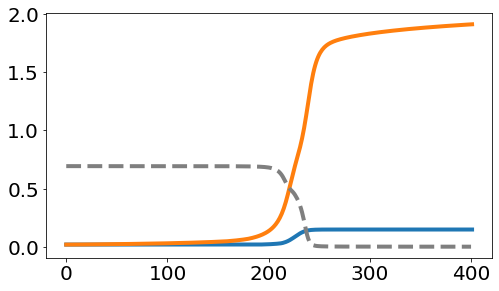

In [8]:
num_epochs = 401

CNN = ConvNet(PATCH_LEN*PATCH_NUM, 20, PATCH_NUM).cuda() 
pred = CNN(test_data)
criterion = torch.nn.CrossEntropyLoss()
test(CNN, criterion, test_data, test_labels)
test(CNN, criterion, small_test_data, small_test_label)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CNN.parameters(), lr=0.03, momentum=0.8)

core, spu, loss_list = train(CNN, criterion, training_data, training_labels, [optimizer], num_epochs, plot=False)
test(CNN, criterion, test_data, test_labels)
test(CNN, criterion, small_test_data, small_test_label)

plt.plot(spu.cpu(),color="tab:blue",linewidth=4,label=r'$\max_{j\in[J]}\langle\mathbf{w}_j^{(t)},\mathbf{v}_s\rangle$')
plt.plot(core.cpu(),color="tab:orange",linewidth=4,label=r'$\max_{j\in[J]}\langle\mathbf{w}_j^{(t)},\mathbf{v}_c\rangle$')
plt.plot(loss_list.cpu(),color="tab:gray",linewidth=4,linestyle='--',label='training loss')

if SAVE:
    plt.savefig(DIR_NAME+"synthetic_GDM_s2.pdf", bbox_inches='tight')